In [1]:
#pip -q install earthaccess

In [2]:
#pip -q install distancerasters

In [3]:
# preliminaries
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
import contextily
import os
from skimage import io
import requests
import pandas as pd
import shapely
from osgeo import gdal
import rioxarray
import xarray
import earthaccess
import distancerasters as dr
from osgeo import gdal
from rasterio.enums import Resampling

# Water qality over time in the Mekong

## Why? 
* The Mekong River is one of the largest and most productive rivers in the world
* The Lower Mekong basin feeds 60 million people per day
* Widespread dam development probably changing water quality

<img src="extras/overview_map.png" alt="drawing" width="30%"/>

## Objectives
Track chlorophyll and turbidity over the last decade in  the Lower Mekong Basin.

## Where? 
I have field data from five sites at the confluence of the Mekong and 3S tributaries

![](extras/sample_locations.png)

## Datasets
* [HydroSHEDs river reaches](https://www.hydrosheds.org/products/hydrorivers) -- for identifying and differentiating river reaches. 
* [JRC water extent](https://global-surface-water.appspot.com/download) -- for delineating where water is (and is not)
* [Harmonized Landsat Sentinel](https://hls.gsfc.nasa.gov/) -- for calculating indices

# Workflow

1. Create water mask for each river reach
1. Get time series of median chlorophyll and turbidity indices for each river reach
1. Analyze time series

## Create water mask for each river reach

### Load sample locations and water mask

Geopandas

In [4]:
sampling_points = gpd.read_file('data/nov_3s.geojson')
# only include site 1 for each location
sampling_points = sampling_points.loc[sampling_points.name.str.contains('1')]

In [5]:
# first create a bounding box of points 20km from sampling points
# re-project to appropriate UTM zone (EPSG:32648) https://epsg.io/32648
sampling_points_utm = sampling_points.to_crs('EPSG:32648')
bounds = sampling_points_utm.unary_union.convex_hull.buffer(40000)
bounds_gdf = gpd.GeoDataFrame(geometry = gpd.GeoSeries( bounds), crs = sampling_points_utm.crs)

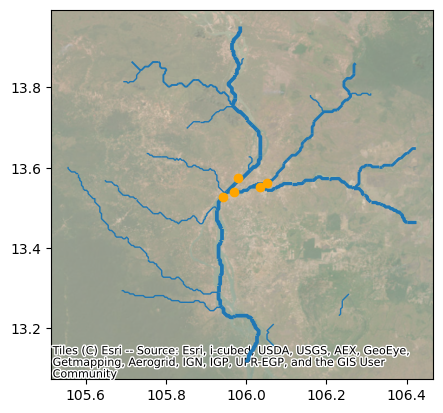

In [6]:
# download from https://www.hydrosheds.org/products/hydrorivers
hr_url = '/home/jovyan/data/HydroRIVERS_v10_as_shp'
rivers = gpd.read_file(hr_url, mask = bounds_gdf).set_index('HYRIV_ID')
ax = rivers[rivers['ORD_STRA']>2].plot(linewidth=rivers[rivers['ORD_STRA']>2]['ORD_STRA']/3, zorder=10)
sampling_points.plot(ax=ax, color = "orange", zorder=20)
contextily.add_basemap(ax, 
                       crs=rivers.crs, 
                       source=contextily.providers.Esri.WorldImagery,
                      alpha = 0.5)

## Identify which hydrosheds reaches are closest to each point.

Spatial Join!

In [7]:
# first reproject rivers to UTM 48
rivers_utm = rivers.to_crs(sampling_points_utm.crs)
# For each sampling point, find closest river reach, 
# ensuring that it matches with the large channel
sampling_points_merged_utm = sampling_points_utm.sjoin_nearest(rivers_utm.loc[rivers['ORD_STRA'] > 5, ['geometry']], how='left')
reaches = rivers_utm.loc[sampling_points_merged_utm['index_right']]


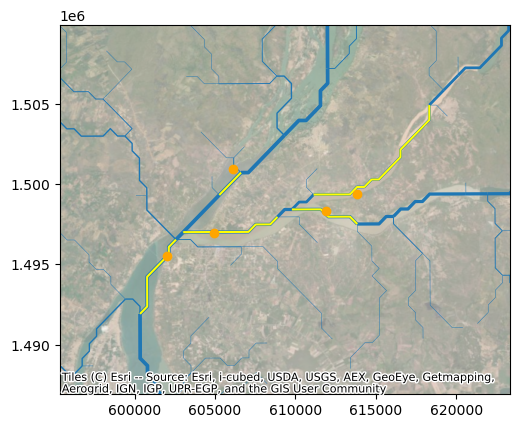

In [8]:
# visualize it
(xmin, ymin, xmax, ymax) = rivers_utm.loc[sampling_points_merged_utm['index_right']].unary_union.bounds
ax = rivers_utm.plot(linewidth=rivers['ORD_STRA']/3, zorder=1)
reaches.plot(ax=ax, color='yellow', zorder=10)
sampling_points_merged_utm.plot(ax=ax, color = "orange", zorder=20)
ax.set_xlim(xmin-5000, xmax+5000)
ax.set_ylim(ymin-5000, ymax+5000)
contextily.add_basemap(ax, 
                       crs=rivers_utm.crs.to_string(), 
                       source=contextily.providers.Esri.WorldImagery, 
                      alpha = 0.5)

### Merge river reaches to fill in missing space

In [9]:

maj_riv = rivers_utm.loc[rivers['ORD_STRA'] > 5, ['geometry', 'NEXT_DOWN']]
for i in reaches.index: 
    
    reach_idx = [i]
    reach = reaches.loc[i]
    # extend DOWN to major tributary
    # Unless it's the most downstream one
    if reaches.loc[i]['DIST_DN_KM'] != min(reaches['DIST_DN_KM']): 

        downstream =  maj_riv.loc[maj_riv.loc[i:(i+1), 'NEXT_DOWN']].index[0]
        tributaries = maj_riv[maj_riv['NEXT_DOWN'] == downstream]
        j=i
        # only add it if there is not a major tributary separating them. 

        while len(tributaries) < 2: 

            # add downstream reach 
            reach_idx.append(downstream)
            # get next downstream reach
            j = downstream
            downstream = maj_riv.loc[maj_riv.loc[j:(j+1), 'NEXT_DOWN']].index[0]
            tributaries = maj_riv[maj_riv['NEXT_DOWN'] == downstream]    

    reaches.loc[i, 'geometry'] = maj_riv.loc[reach_idx].unary_union

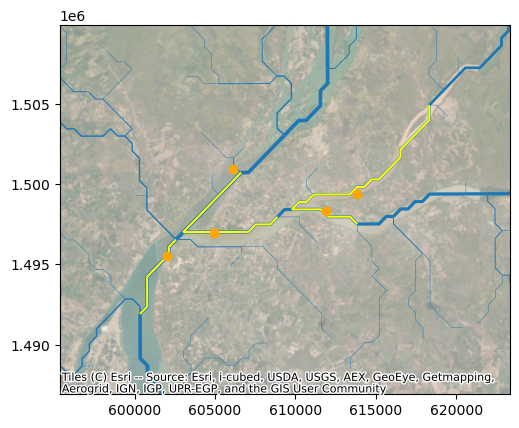

In [10]:
# visualize it
(xmin, ymin, xmax, ymax) = rivers_utm.loc[sampling_points_merged_utm['index_right']].unary_union.bounds
ax = rivers_utm.plot(linewidth=rivers['ORD_STRA']/3, zorder=1)
reaches.plot(ax=ax, color='yellow', zorder=10)
sampling_points_merged_utm.plot(ax=ax, color = "orange", zorder=20)
ax.set_xlim(xmin-5000, xmax+5000)
ax.set_ylim(ymin-5000, ymax+5000)
contextily.add_basemap(ax, 
                       crs=rivers_utm.crs.to_string(), 
                       source=contextily.providers.Esri.WorldImagery, 
                      alpha = 0.5)

## Create water mask for each river reach

rioxarray and [distancerasters](https://github.com/sgoodm/python-distance-rasters)

Use Water classification raster dataset. 

### Water classification dataset

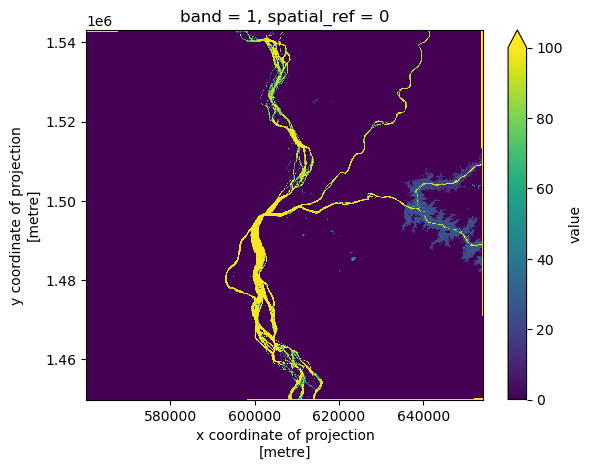

In [11]:

# open JRC wter classification dataset using rioxarray
water_xds = rioxarray.open_rasterio('/home/jovyan/data/occurrence_100E_20Nv1_4_2021.tif', masked=True).squeeze()

# Select only a window around the area I'm interested in
# don't use utm rivers because water ds is not in utm. 
window_bounds = rivers.unary_union.bounds
window_extent = [window_bounds[0], window_bounds[2], window_bounds[1], window_bounds[3]]
window = rio.windows.from_bounds(*window_bounds, transform=water_xds.rio.transform())

# Filter to only that window
water_sel_xds = water_xds.rio.isel_window(window=window)

#Using nearest neighbor resampling
water_proj = water_sel_xds.rio.reproject('EPSG:32648')
# and plot
water_proj.plot.imshow(vmin=0, vmax=100)


### Clip to buffer and choose threshold

/srv/conda/envs/notebook/lib/python3.11/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


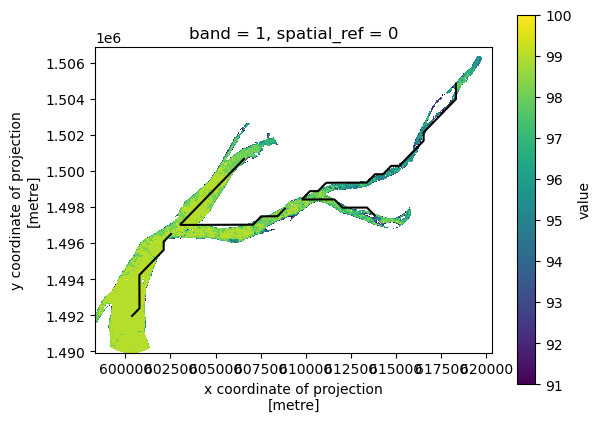

In [12]:
# create 2km mask around each river vector
buff = gpd.GeoDataFrame(geometry=gpd.GeoSeries(reaches['geometry'].buffer(2000).unary_union))

# clip water dataset to buffer
water_buff = water_proj.rio.clip(buff.geometry.values, drop=True)
water_buff = water_buff.where(water_buff != water_buff.rio.nodata)
water_buff.rio.write_nodata(water_buff.rio.nodata, encoded=True, inplace=True)

# Set 90% threshold
water_90 = water_buff.where(water_buff > 90)

fig, ax = plt.subplots()
water_90.plot.imshow(interpolation='none', ax=ax)
reaches.plot(ax=ax, color = 'k');


### Classify pixels based on distance to river reach

For each pixel, assign it to the river reach it is closes to. 

Use distancerasters package to calculate distance to river reach for each pixel.

#### Example

In [13]:
i=0
reach = reaches.geometry.values[0]
ar, tr = dr.rasterize(reach, pixel_size=30, bounds=water_90.rio.bounds())
r = dr.DistanceRaster(ar)

Tree build time: 0.0023 seconds
Distance calc run time: 15.664 seconds


<Axes: >

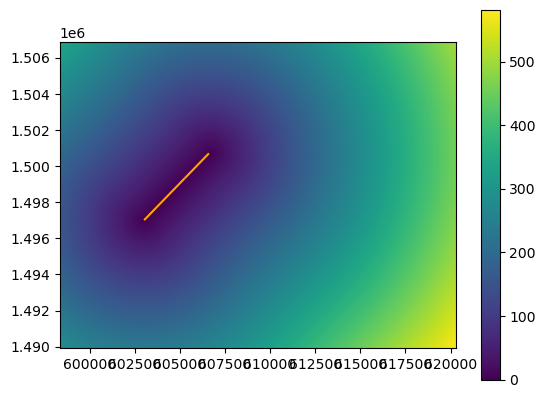

In [14]:
fig, ax = plt.subplots()
b = water_90.rio.bounds()
im = ax.imshow(r.dist_array, extent=[b[0], b[2], b[1], b[3]])
fig.colorbar(im)
reaches.iloc[0:1,:].plot(color='orange', ax=ax)

Repeat this for all river reaches.

Then use rioxarray and argmin over each distanceraster
to identify which reach is closest to each pixel.

### End result

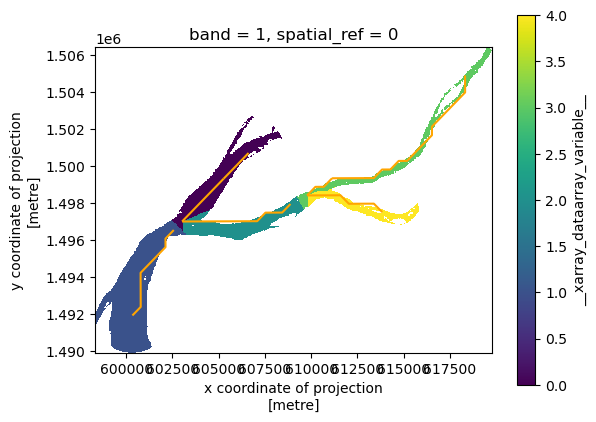

In [15]:
# load and plot reach mask
reach_mask = rioxarray.open_rasterio('data/external/river_reach_mask.nc', masked=True).squeeze()
reach_mask = reach_mask.rio.write_crs('EPSG:32648')
fig, ax = plt.subplots()
reach_mask.plot.imshow(ax=ax)
reaches.plot(ax=ax, color='orange');

# Get time series of median chlorophyll and turbidity indices for each river reach

* Normalized difference turbidity index
    * NDTI = (Red – Green)/(Red + Green)
    
    
* Normalized difference chlorophyll index
    * NDCI = (NIR - Red)/(NIR + Red)

Use [earthaccess](https://github.com/nsidc/earthaccess/) to pull HLS data

In [16]:
import earthaccess

### Preliminaries from earthaccess tutorial

In [17]:
# EarthAccess setup for HLS
# https://github.com/nasa/HLS-Data-Resources/blob/main/python/tutorials/HLS_Tutorial.ipynb

earthaccess.login(persist=True)

In [18]:

# GDAL configurations used to successfully access LP DAAC Cloud Assets via vsicurl 
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')
gdal.SetConfigOption('GDAL_HTTP_UNSAFESSL', 'YES')

## Set up parameters for pulling data

Time limit

In [19]:
# look for data over the sampling dates 
# (Nov 20, 21, 29, & 30, 2023)
temporal = ("2023-11-20T00:00:00", "2023-11-30T23:59:59")

Spatial limit

In [20]:
#xds_lonlat = xds.rio.reproject("EPSG:4326")
bounds_proj = reach_mask.rio.bounds()
bounds_latlon = reach_mask.rio.reproject('EPSG:4326').rio.bounds()

In [21]:
results = earthaccess.search_data(
    short_name=['HLSS30'], # only query sentinel for now
    bounding_box=bounds_latlon,
    temporal=temporal,
    count=100
)
results_df = pd.json_normalize(results)

Granules found: 7


There are four different sentinel tile which overlap with these samples (annoyingly).

I created reach masks which line up with each tile to make masking easy. 

In [22]:

mask_pwv = rioxarray.open_rasterio('data/external/reach_mask_PWV.tif').squeeze()
mask_pwa = rioxarray.open_rasterio('data/external/reach_mask_PWA.tif').squeeze()
mask_pxv = rioxarray.open_rasterio('data/external/reach_mask_PXV.tif').squeeze()
mask_pxa = rioxarray.open_rasterio('data/external/reach_mask_PXA.tif').squeeze()


# Pull the data

Start with just the first image and reach. 

In [23]:
hls_results_urls = [granule.data_links() for granule in results]

In [24]:
h = hls_results_urls[0]  

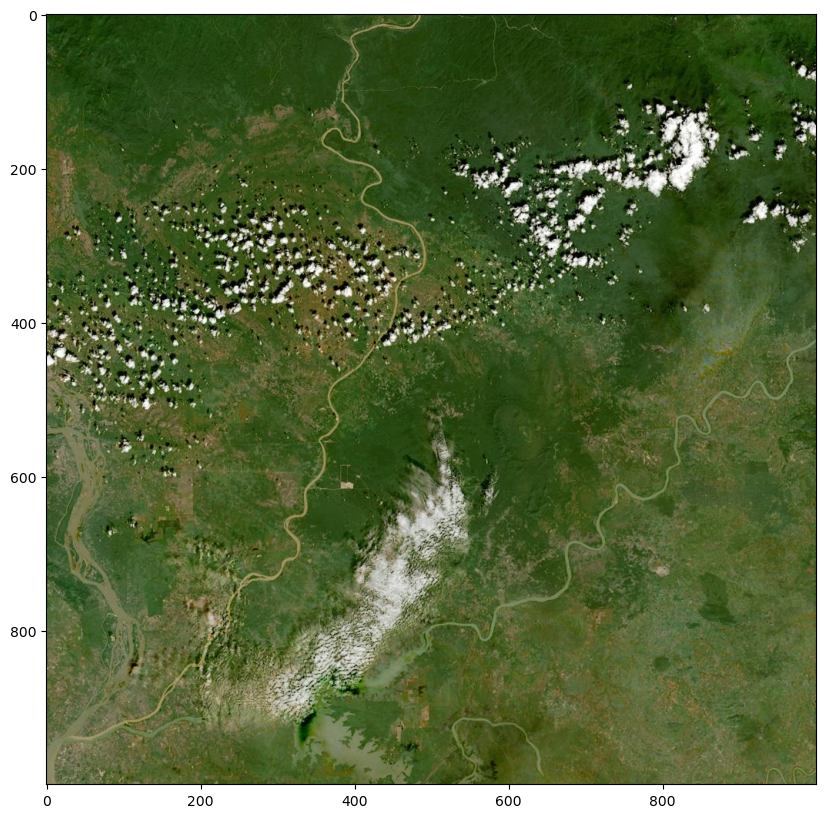

In [25]:

browse_urls = [granule.dataviz_links()[0] for granule in results] # 0 retrieves only the https links

image = io.imread(browse_urls[0])  # Load jpg browse image into memory

# Basic plot of the image
plt.figure(figsize=(10,10))              
plt.imshow(image)
plt.show()

### Get urls for data I want

In [26]:
# Pull fmask, red, green, NIR
# Fmask, B04, B03, B05
band_links = []

# Define which HLS product is being accessed
bands = ['Fmask', 'B04', 'B03', 'B05'] 

# Subset the assets in the item down to only the desired bands
for url in h: 
    if any(b in url for b in bands):
        band_links.append(url)

## Pull HLS data into memory using rioxarray

In [27]:
# Use vsicurl to load the data directly into memory (be patient, may take a few seconds)
chunk_size = dict(band=1, x=512, y=512) # Tiles have 1 band and are divided into 512x512 pixel chunks
# Sometimes a vsi curl error occurs so we need to retry if it does
max_retries = 1
for url in band_links:
    print(url)
    # Try Loop
    for _i in range(max_retries):
        try:
            # Open and build datasets
            if url.rsplit('.', 2)[-2] == bands[0]:      # Fmask index
                fmask = rioxarray.open_rasterio(url, chunks=chunk_size, masked=True).squeeze('band', drop=True)
            elif url.rsplit('.', 2)[-2] == bands[1]:    # Red index
                red = rioxarray.open_rasterio(url, chunks=chunk_size, masked=True).squeeze('band', drop=True)
                red.attrs['scale_factor'] = 0.0001        # hard coded the scale_factor attribute
            elif url.rsplit('.', 2)[-2] == bands[2]:    # Green index
                green = rioxarray.open_rasterio(url, chunks=chunk_size, masked=True).squeeze('band', drop=True)
                green.attrs['scale_factor'] = 0.0001       # hard coded the scale_factor attribute
            elif url.rsplit('.', 2)[-2] == bands[3]:    # NIR index
                nir = rioxarray.open_rasterio(url, chunks=chunk_size, masked=True).squeeze('band', drop=True)
                nir.attrs['scale_factor'] = 0.0001       # hard coded the scale_factor attribute
            break # Break out of the retry loop
        except Exception as ex:
            print(f"vsi curl error: {ex}. Retrying...")
    else:
        print(f"Failed to process {url} after {max_retries} retries. Please check to see you're authenticated with earthaccess.")
print("The COGs have been loaded into memory!")

https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T48PXA.2023325T032029.v2.0/HLS.S30.T48PXA.2023325T032029.v2.0.B04.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T48PXA.2023325T032029.v2.0/HLS.S30.T48PXA.2023325T032029.v2.0.Fmask.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T48PXA.2023325T032029.v2.0/HLS.S30.T48PXA.2023325T032029.v2.0.B05.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T48PXA.2023325T032029.v2.0/HLS.S30.T48PXA.2023325T032029.v2.0.B03.tif
The COGs have been loaded into memory!


### Turn it into xarray dataset

In [28]:
hls_ds = fmask.to_dataset(name='fmask')
hls_ds['red'] = red
hls_ds['green'] = green
hls_ds['nir'] = nir
hls_ds

<xarray.Dataset>
Dimensions:      (x: 3660, y: 3660)
Coordinates:
  * x            (x) float64 6e+05 6e+05 6.001e+05 ... 7.098e+05 7.098e+05
  * y            (y) float64 1.6e+06 1.6e+06 1.6e+06 ... 1.49e+06 1.49e+06
    spatial_ref  int64 0
Data variables:
    fmask        (y, x) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>
    red          (y, x) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>
    green        (y, x) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>
    nir          (y, x) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>

## Filter to only one reach

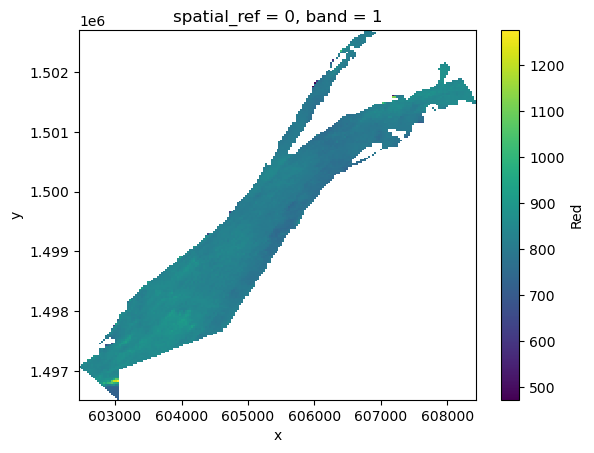

In [29]:
reach_0 = hls_ds.where(mask_pxa == 0, drop=True)
reach_0['red'].plot.imshow()

# Remove clouds, and any pixels which do not pass QC
Also record number of pixels which did pass QC

In [30]:
# Get value of QC bit based on location
def get_qc_bit(ar, bit):
    return ( (ar // (2**bit)) - ( (ar // (2**bit)) // 2 * 2) )

# Not cloud
cloud_mask = (
    (get_qc_bit(reach_0['fmask'], 1) == 0) & # not cloud
    (get_qc_bit(reach_0['fmask'], 2) == 0) & # not cloud adjacent
    (get_qc_bit(reach_0['fmask'], 3) == 0)   # not cloud shadow
)

reach_0_qa = reach_0.where(cloud_mask)
reach_0_failed_count = reach_0['red'].count().values - reach_0_qa['red'].count().values
reach_0_qa.attrs['failed_pixel_count'] = reach_0_failed_count
reach_0_qa.attrs['total_pixel_count'] = reach_0['red'].count().values
print(reach_0_failed_count)


0


### Calculate NDCI and NDTI

Then get median

-0.024641834

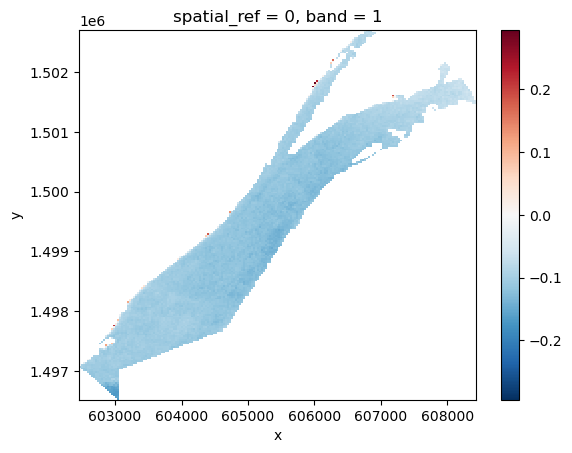

In [31]:
# NDTI
def ndti(dataset): 
    ndti = (dataset['red'] - dataset['green']) / (dataset['red'] + dataset['green'])
    return(ndti)

# ndci
def ndci(dataset):
    ndci = (dataset['nir'] - dataset['red']) / (dataset['nir'] + dataset['red'])
    return(ndci)

ndci(reach_0.where(cloud_mask)).plot.imshow()
np.nanmedian(ndti(reach_0.where(cloud_mask)).values)

# Repeat for all reaches and days

This took about 16 hours to run... 

Here's just a pull of the metadata. 

In [32]:
# Run for an entire year. 
# 502 granules. That's quite a few. 
# This may take many hours to run. 
# I might have to update some things to run more than one year. 
# Let's start with this. 
temporal = ("2017-07-01T00:00:00", "2024-10-01T23:59:59")
results = earthaccess.search_data(
    short_name=['HLSS30'], 
    bounding_box=bounds_latlon,
    temporal=temporal
)

Granules found: 1661


# Analyze some time series!

In [33]:
from datetime import datetime

### Load the final result
and do a little cleanup

In [34]:
hls = pd.read_csv('data/results_hls_sentinel.csv',
            index_col='meta.native-id')
# name reaches
reach_dict = {0: 'kscs', 1: 'sts', 2: '3sb', 3: 'skg', 4: 'ssn'}
hls['reach_name'] = [reach_dict[r] for r in hls['reach']]

# remove dates with 
# reflectance values > 2000
hls = hls.loc[hls['red'] < 2000]

hls['date'] = [datetime.date(d) for d in pd.to_datetime(hls['start_time'])]

# scale factor
hls.loc[:, ['red', 'green', 'nir']] = hls.loc[:, ['red', 'green', 'nir']]  * 0.0001

hls

Unnamed: 0     platform tile  \
meta.native-id                                                     
HLS.S30.T48PWA.2017211T031541.v2.0           5  Sentinel-2A  PWA   
HLS.S30.T48PXA.2017211T031541.v2.0           6  Sentinel-2A  PXA   
HLS.S30.T48PWV.2017211T031541.v2.0           7  Sentinel-2A  PWV   
HLS.S30.T48PXV.2017211T031541.v2.0           8  Sentinel-2A  PXV   
HLS.S30.T48PXV.2017226T031539.v2.0          16  Sentinel-2B  PXV   
...                                        ...          ...  ...   
HLS.S30.T48PXA.2024050T031759.v2.0        8293  Sentinel-2B  PXA   
HLS.S30.T48PXA.2024055T031721.v2.0        8297  Sentinel-2A  PXA   
HLS.S30.T48PXV.2024055T031721.v2.0        8299  Sentinel-2A  PXV   
HLS.S30.T48PXA.2024060T031649.v2.0        8301  Sentinel-2B  PXA   
HLS.S30.T48PXV.2024060T031649.v2.0        8303  Sentinel-2B  PXV   

                                                  start_time  \
meta.native-id                                                 
HLS.S30.T48PWA.2017211T031541.v2.0  2017-07-30T03:32:09.980Z   
HLS.S30.T48PXA.2017211T031541.v2.0  2017-07-30T03:32:09.980Z   
HLS.S30.T48PWV.2017211T031541.v2.0  2017-07-30T03:32:09.980Z   
HLS.S30.T48PXV.2017211T031541.v2.0  2017-07-30T03:32:09.980Z   
HLS.S30.T48PXV.2017226T031539.v2.0  2017-08-14T03:32:09.590Z   
...                                                      ...   
HLS.S30.T48PXA.2024050T031759.v2.0  2024-02-19T03:34:15.022Z   
HLS.S30.T48PXA.2024055T031721.v2.0  2024-02-24T03:34:12.408Z   
HLS.S30.T48PXV.2024055T031721.v2.0  2024-02-24T03:34:27.021Z   
HLS.S30.T48PXA.2024060T031649.v2.0  2024-02-29T03:34:12.230Z   
HLS.S30.T48PXV.2024060T031649.v2.0  2024-02-29T03:34:26.839Z   

                                                    end_time  reach      red  \
meta.native-id                                                                 
HLS.S30.T48PWA.2017211T031541.v2.0  2017-07-30T03:32:09.980Z      0  0.17590   
HLS.S30.T48PXA.2017211T031541.v2.0  2017-07-30T03:32:09.980Z      0  0.17790   
HLS.S30.T48PWV.2017211T031541.v2.0  2017-07-30T03:32:09.980Z      0  0.18740   
HLS.S30.T48PXV.2017211T031541.v2.0  2017-07-30T03:32:09.980Z      0  0.18950   
HLS.S30.T48PXV.2017226T031539.v2.0  2017-08-14T03:32:09.590Z      0  0.17310   
...                                                      ...    ...      ...   
HLS.S30.T48PXA.2024050T031759.v2.0  2024-02-19T03:34:15.022Z      4  0.02955   
HLS.S30.T48PXA.2024055T031721.v2.0  2024-02-24T03:34:12.408Z      4  0.03600   
HLS.S30.T48PXV.2024055T031721.v2.0  2024-02-24T03:34:27.021Z      4  0.03560   
HLS.S30.T48PXA.2024060T031649.v2.0  2024-02-29T03:34:12.230Z      4  0.03170   
HLS.S30.T48PXV.2024060T031649.v2.0  2024-02-29T03:34:26.839Z      4  0.02860   

                                     green      nir      ndti      ndci  \
meta.native-id                                                            
HLS.S30.T48PWA.2017211T031541.v2.0  0.1287  0.16770  0.156527 -0.022204   
HLS.S30.T48PXA.2017211T031541.v2.0  0.1310  0.16950  0.153087 -0.022835   
HLS.S30.T48PWV.2017211T031541.v2.0  0.1378  0.17880  0.153396 -0.023974   
HLS.S30.T48PXV.2017211T031541.v2.0  0.1401  0.18100  0.150961 -0.021535   
HLS.S30.T48PXV.2017226T031539.v2.0  0.1359  0.15750  0.114062 -0.046019   
...                                    ...      ...       ...       ...   
HLS.S30.T48PXA.2024050T031759.v2.0  0.0452  0.01370 -0.210248 -0.335913   
HLS.S30.T48PXA.2024055T031721.v2.0  0.0558  0.02440 -0.214570 -0.202240   
HLS.S30.T48PXV.2024055T031721.v2.0  0.0564  0.02370 -0.220191 -0.207993   
HLS.S30.T48PXA.2024060T031649.v2.0  0.0466  0.02360 -0.190204 -0.146536   
HLS.S30.T48PXV.2024060T031649.v2.0  0.0430  0.01955 -0.209632 -0.181120   

                                    qc_fail_pixels  total_pixels reach_name  \
meta.native-id                                                                
HLS.S30.T48PWA.2017211T031541.v2.0          1689.0        7421.0       kscs   
HLS.S30.T48PXA.2017211T031541.v2.0          1575.0        7421.0

### Aggregate by date

In [35]:
# aggregate by date

# use a weighted mean
# weighted by number of valid pixels
# add column for number of valid pixels
hls['valid_pixels'] = hls['total_pixels'] - hls['qc_fail_pixels'] 

def weighted_mean(df, col, weights_col = 'valid_pixels', threshold = 3000): 
    total_weights = df[weights_col].sum()
    if (total_weights > threshold):
        weight = df[col] * df[weights_col] / total_weights
        return(weight.sum())
    else: 
        return(np.nan)

red_mean = hls.groupby(['date', 'reach_name']).apply(weighted_mean, 'red')
green_mean = hls.groupby(['date', 'reach_name']).apply(weighted_mean, 'green')
nir_mean = hls.groupby(['date', 'reach_name']).apply(weighted_mean, 'nir')
ndti_mean = hls.groupby(['date', 'reach_name']).apply(weighted_mean, 'ndti')
ndci_mean = hls.groupby(['date', 'reach_name']).apply(weighted_mean, 'ndci')


In [36]:
hls_agg = pd.DataFrame({'red': red_mean, 
              'green': green_mean,
              'nir': nir_mean, 
              'ndti': ndti_mean, 
              'ndci': ndci_mean}).reset_index()

## Calculate rolling average

In [37]:
# Calculate rolling average for plotting
# Create list of evenly spaced dates
dates = pd.date_range(
    start=min(hls['date']),
    end=max(hls['date']),
    freq=pd.Timedelta(value=5, unit='D', )
)
hls_smooth = pd.DataFrame({'date': [], 'reach': [], 'variable': [], 'value': []})

In [38]:
# for each of those dates, 
# calculate the 40-day average
reaches = [ 'kscs', 'sts', 'ssn', '3sb', 'skg']
window = 40
hls_agg['date_ts'] = [pd.Timestamp(d) for d in hls_agg['date']]
for column in ['red', 'green', 'nir', 'ndci', 'ndti']: 
    for reach in reaches: 
        for d in dates: 
            start = d - pd.Timedelta(value=window/2, unit='D', )
            end = d + pd.Timedelta(value=window/2, unit='D', )
            average = hls_agg.loc[(hls_agg['date_ts'] >= start) & 
                                  (hls_agg['date_ts'] <= end) & 
                                  (hls_agg['reach_name'] == reach), column].mean()
            hls_smooth = pd.concat([hls_smooth, 
                         pd.DataFrame({'date': [d], 
                                     'reach': [reach], 
                                     'variable': [column], 
                                     'value': [average]})])
    

# Compare all variables for all reaches

In [39]:
def plot_hls_timeseries(ax, var, reach, color, label): 
    df_smooth = hls_smooth.loc[(hls_smooth['variable'] == var) & 
                         (hls_smooth['reach'] == reach)]
    df = hls_agg.loc[(hls_agg['reach_name'] == reach)]

    ax.scatter(df['date'], df[var], s=2, alpha = 0.5, color = color)
    ax.plot(df_smooth['date'], df_smooth['value'],
            linewidth = 1.5,
            label = label,
           color = color)

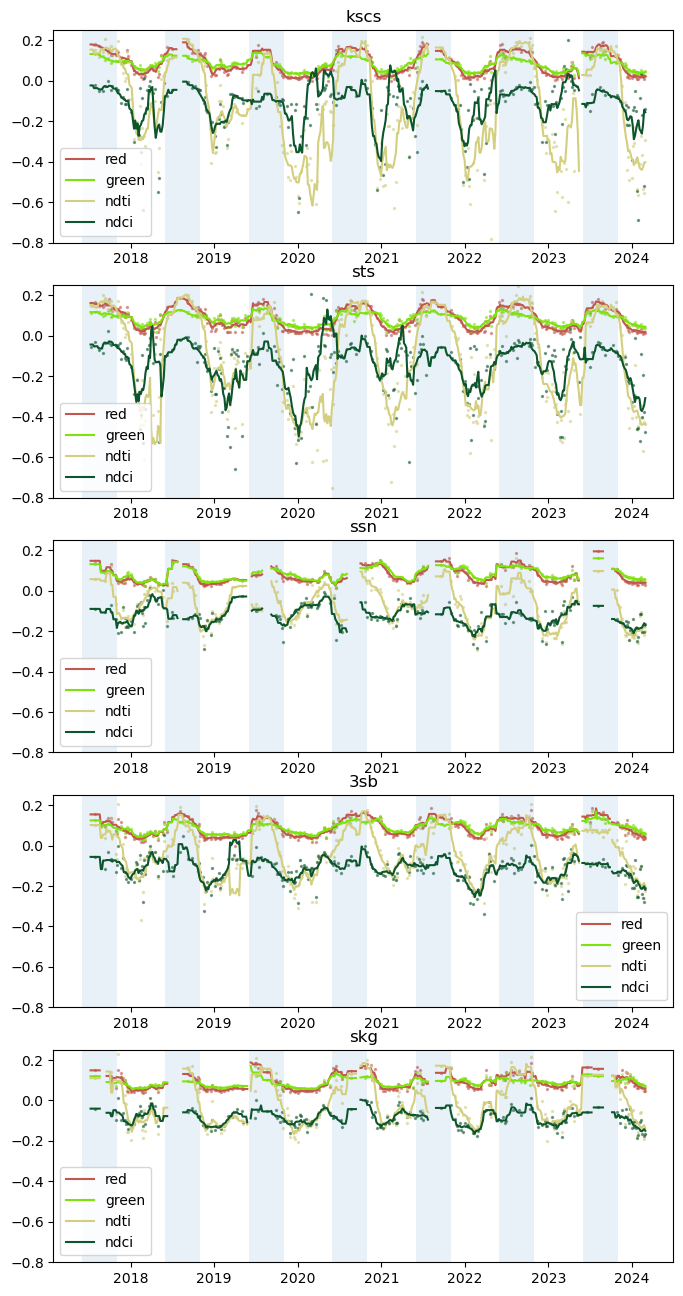

In [40]:
fig, ax = plt.subplots(5, 1, figsize=(8, 16))


for i, reach in enumerate(reaches): 
    for var, color in zip(['red', 'green', 'ndti', 'ndci'], 
                          ['#c1574d', '#7fe20d', '#d3cf7e', '#0d562d']): 
        plot_hls_timeseries(ax[i], var, reach, color, var)
    ax[i].legend()
    ax[i].set_ylim(-.8, 0.25)
    ax[i].set_title(reach)
    for year in ['2017', '2018', '2019', '2020', '2021', '2022', '2023']: 
        ax[i].axvspan(datetime.date(datetime.fromisoformat(f'{year}-06-01')), 
                   datetime.date(datetime.fromisoformat(f'{year}-11-01')), alpha=0.1)


Text(0.5, 1.0, 'NDCI for all reaches')

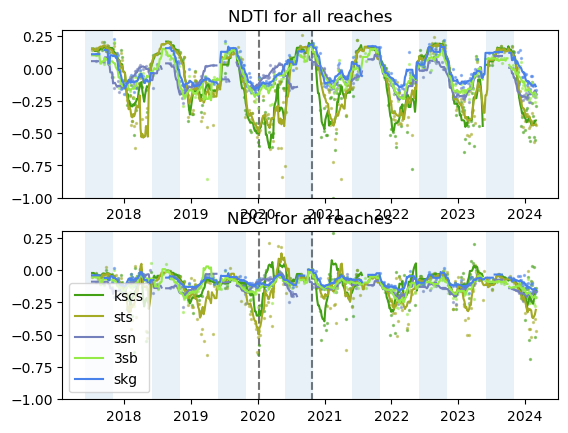

In [41]:
colors = ['#43a014', '#a4aa23', '#7380bc', '#96ea48', '#4881ea']
fig, ax = plt.subplots(2, 1)
    
for reach, color in zip(reaches, colors): 
    plot_hls_timeseries(ax[0], 'ndti', reach, color, reach)


for reach, color in zip(reaches, colors): 
    plot_hls_timeseries(ax[1], 'ndci', reach, color, reach)


for a in ax: 
    a.set_ylim(-1, 0.3)
    for year in ['2017', '2018', '2019', '2020', '2021', '2022', '2023']: 
        a.axvspan(datetime.date(datetime.fromisoformat(f'{year}-06-01')), 
                   datetime.date(datetime.fromisoformat(f'{year}-11-01')), alpha=0.1)
        a.vlines([datetime.date(datetime.fromisoformat('2020-01-06')),
                  datetime.date(datetime.fromisoformat('2020-10-22'))],
                 ymin=-100, ymax=100, zorder=-100, color='k', alpha=0.1, 
                linestyle='--')
ax[1].legend()
ax[0].set_title('NDTI for all reaches')
ax[1].set_title('NDCI for all reaches')



## Jan 6, 2020
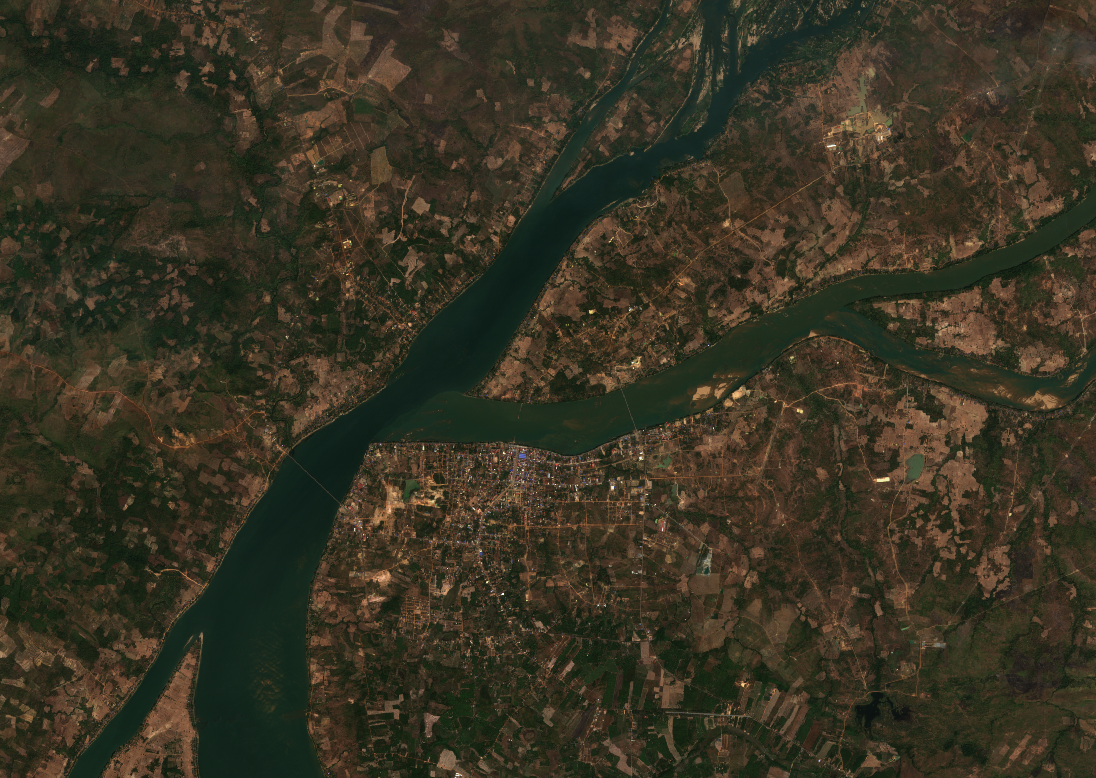

## Oct 22, 2020
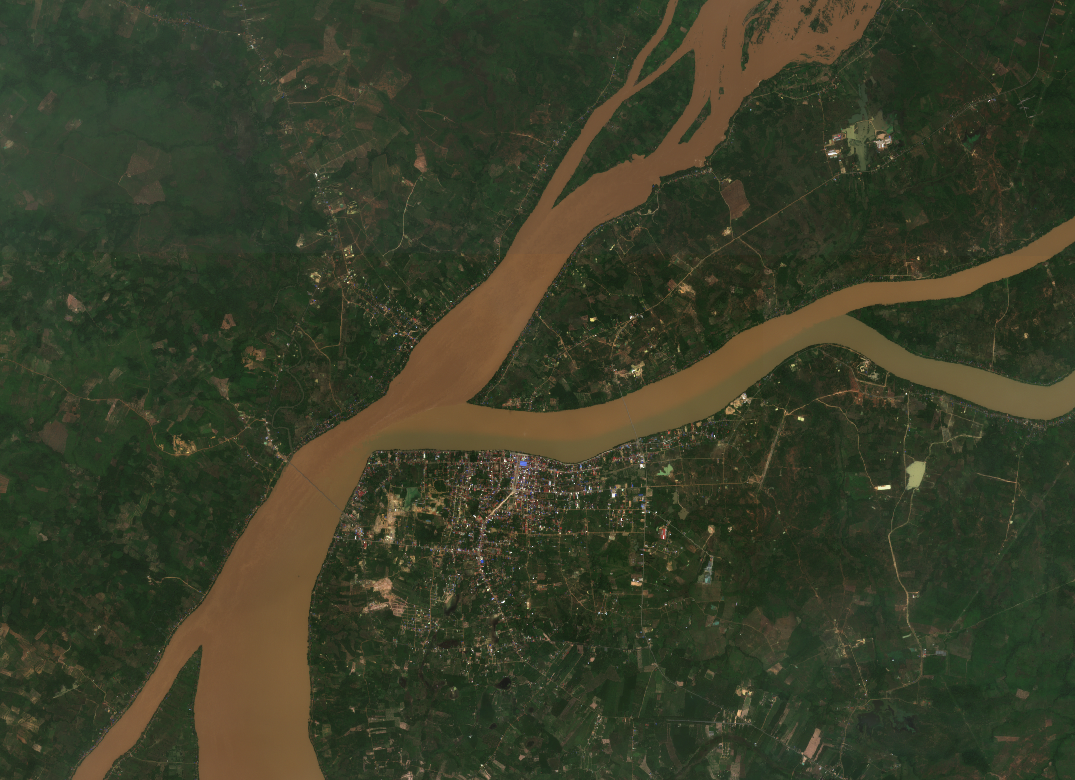